only difference here is the database i'm using 
paladins1.db has the pro games on it

In [17]:
import pandas as pd
import sqlite3 as sq
from sklearn.model_selection import train_test_split


conn = sq.connect("../paladins1.db")

df = pd.read_sql_query("SELECT * FROM match", conn)

df["result"] = df["result"].apply(lambda x: 0 if x == 'L' else 1)

print(df[df['result'] == 1])

             username  champ_level   k   d   a  credits  cpm  result  \
5            CrashG17           59  11  14  14     3194  319       1   
6           Dyeusinda           58   5  12  12     2882  288       1   
7           Erick_Pri           60   9  13  13     3144  314       1   
8         Toritllas24           59   5  19  19     3375  338       1   
9            xdMoraxd           48  11  16  16     2972  297       1   
...               ...          ...  ..  ..  ..      ...  ...     ...   
10249   JUST1NSEAGULL           55   1  13  13     5463  607       1   
10250  Marionette2000           60   3  17  17     4769  530       1   
10251        gdegovno           20   5  10  10     4256  473       1   
10252        gigadaun           30  14  13  13     5204  578       1   
10253       gleamcito           59  20   5   5     5205  578       1   

        champion  damage  weapon  healing  self_heal   taken  shielding  \
5        Unknown   60866   42059        0        859   33216

In [18]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['champion'], df['result'])

print("Contingency Table:\n", contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

# Interpretation
if p_value > 0.05:
    print("Fail to reject the null hypothesis: No relationship between predictor and target.")
else:
    print("Reject the null hypothesis: There is a relationship between predictor and target.")


Contingency Table:
 result            0    1
champion                
Androxus        136  134
Ash              91   92
Atlas            56   56
Azaan            77   82
Barik            79   68
Betty la Bomba   64   75
Bomb King        64   62
Buck             56   58
Caspian          30   24
Cassie           77   78
Corvus           61   57
Dredge          100  101
Drogoz          114  120
Evie             82   52
Fernando        121  187
Furia            80   87
Grohk            50   52
Grover           84   84
Imani            88   80
Inara            86  118
Io              108  121
Jenos           180  206
Kasumi           56   43
Khan            151  180
Kinessa          97   91
Koga             76   83
Lex              52   78
Lian            113  116
Lillith          66   63
Maeve            99   83
Makoa           136   96
Mal'Damba       101   81
Moji             32   36
Nyx              49   58
Octavia          62   45
Pip              73   60
Raum             67   68
Rei  

In [19]:
df = pd.get_dummies(df, columns=["champion"], dtype=int)
champion_cols = [col for col in df.columns if col.startswith("champion_")]
agg_dict = {col: 'sum' for col in champion_cols}
agg_dict.update({"result" : "first", "match_id" : "first"})

df = df.groupby(["match_id", "result"], as_index=False).agg(agg_dict).reset_index()

X = df[champion_cols]
y = df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.5413533834586466
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.53      0.53       200
           1       0.54      0.56      0.55       199

    accuracy                           0.54       399
   macro avg       0.54      0.54      0.54       399
weighted avg       0.54      0.54      0.54       399



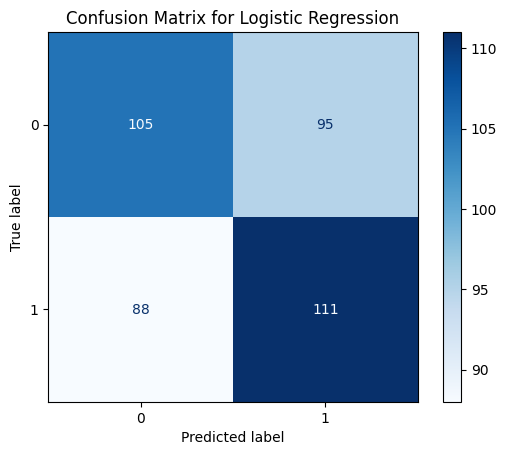

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Logistic Regression Model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


going to try predicting by inputing both teams now

In [26]:
winners = df[df['result'] == 1].add_suffix('_Team_A')
losers = df[df['result'] == 0].add_suffix('_Team_B')

# Merge winners and losers on match_id
merged = pd.merge(winners, losers, left_on='match_id_Team_A', right_on='match_id_Team_B')
merged['target'] = 1  # Team A is always the winner

# Keep only relevant columns
merged = merged.drop(columns=['result_Team_A', 'result_Team_B', 'index_Team_A', 'index_Team_B'])

# Final dataset
print(merged)

X = merged.drop(columns=['target', 'match_id_Team_A', 'match_id_Team_B'])
y = merged['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


     champion_Androxus_Team_A  champion_Ash_Team_A  champion_Atlas_Team_A  \
0                           0                    0                      0   
1                           0                    0                      0   
2                           0                    0                      0   
3                           0                    0                      0   
4                           1                    0                      0   
..                        ...                  ...                    ...   
992                         1                    0                      0   
993                         0                    0                      0   
994                         0                    0                      0   
995                         0                    0                      0   
996                         0                    0                      0   

     champion_Azaan_Team_A  champion_Barik_Team_A  \
0                     